In [1]:
from os import chdir
from pathlib import Path
import scipy as sp
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(Path.cwd())

c:\Users\Peter\git-repos\pit-storm\wi-sem_rl-pong\notebooks


# Important

Be sure that the working directory of the notebook (see cell above) is `[something]\rl-pong\notebooks`. If this is true, than all following cells run correctly. If not, uncomment the following cell and adjust the var `path_to_repo_root` to the absolute path to root dir of this repo.

In [3]:
# path_to_repo_root = "" # Has to be absolute path begin with e.g. C:\ on windows and / on unix systems
# chdir(Path(path_to_repo_root)/"notebooks")

In [4]:
# Set wd to repos root folder
chdir(Path(".."))

In [5]:
# set some path vars
home_dir = Path.cwd()
result_dir = home_dir / "results"


In [6]:
# get all score files
score_files = [file for file in result_dir.rglob("*") if file.match("scores.txt")]

In [7]:
# seperate the score file to random and experiment
random_score_files = [file for file in score_files if file.parent.parent.match("random")]
experiment_score_files = [file for file in score_files if file.parent.parent.match("*advantage")]

In [8]:
# pull out the random scores out of the files
random_scores = {"scores": []}
for file in random_score_files:
    with file.open() as f:
        for line in f:
            random_scores["scores"].append(line[:-1])
# store it as dataframe
df_rand_scores = pd.DataFrame(random_scores).sample(n=320)
# ...and set the correct dtype
df_rand_scores = df_rand_scores.astype(dtype={"scores": "float"})

# store the two different experiment eval data to a dict as dataframe to...
frames = {}
for score_file in experiment_score_files:
    frames[score_file.parent.parent.name] = \
        pd.read_table(filepath_or_buffer=score_file,
            header=0,
            index_col=False,
            encoding="utf-8"
        )

# than pulling it out to seperate dfs
df_advantage_eval = frames["advantage"]
df_disadvantage_eval = frames["disadvantage"]

In [9]:
# compute eval metrics for random agent
rand_eval = {
                "obs": [df_rand_scores.count()[0]],
                "mean": [df_rand_scores.mean(axis=0)[0]]
            }

# and store it to df
df_rand_eval = pd.DataFrame(rand_eval)

In [10]:
# store ttest results to vars
experiments_ttest_t, experiments_ttest_p = scipy.stats.ttest_ind_from_stats(
    mean1=df_advantage_eval["mean"],
    std1=df_advantage_eval["stdev"],
    nobs1=df_advantage_eval.count()[0],
    mean2=df_disadvantage_eval["mean"],
    std2=df_disadvantage_eval["stdev"],
    nobs2=df_disadvantage_eval.count()[0]
)

# creating a df with that vars
df_experiments_tests = pd.DataFrame({"t-test_t-wert": experiments_ttest_t, "t-test_p-wert": experiments_ttest_p})

In [11]:
def calc_cohens_d(mean_1, stdev_1, mean_2, stdev_2):
    """
    Calculate Cohen's D
    args:
        - mean_1: array of first sample mean(s)
        - stdev_2: array of first sample standard eviation(s)
        - mean_2: like mean_1
        - stdev_2: like stdev_1
    returns:
        - list of cohen's d values
    """
    assert len(mean_1) == len(mean_2) == len(stdev_1) == len(stdev_2), \
    "parameters must be of the same length"
    assert not isinstance(mean_1, list) or not isinstance(mean_2, list) or \
    not isinstance(stdev_1, list) or not isinstance(stdev_2, list), \
    "paramers must be of type list"

    cohens_d = []
    for i in range(len(mean_1)):
        tmp = (mean_1[i] - mean_2[i]) / ((stdev_1[i]**2 + stdev_2[i]**2) / 2)**0.5
        cohens_d.append(tmp)
    return cohens_d

In [12]:
# getting cohen's d an storeing it to the df
df_experiments_tests["cohens_d"] = calc_cohens_d(
    mean_1=df_advantage_eval["mean"],
    stdev_1=df_advantage_eval["stdev"],
    mean_2=df_disadvantage_eval["mean"],
    stdev_2=df_disadvantage_eval["stdev"],
)

In [13]:
# helper var for plotting
training_mean = {
    "advantage": df_advantage_eval['mean'],
    "disadvantage": df_disadvantage_eval['mean'],
    "random": np.full(320, df_rand_eval["mean"])
}

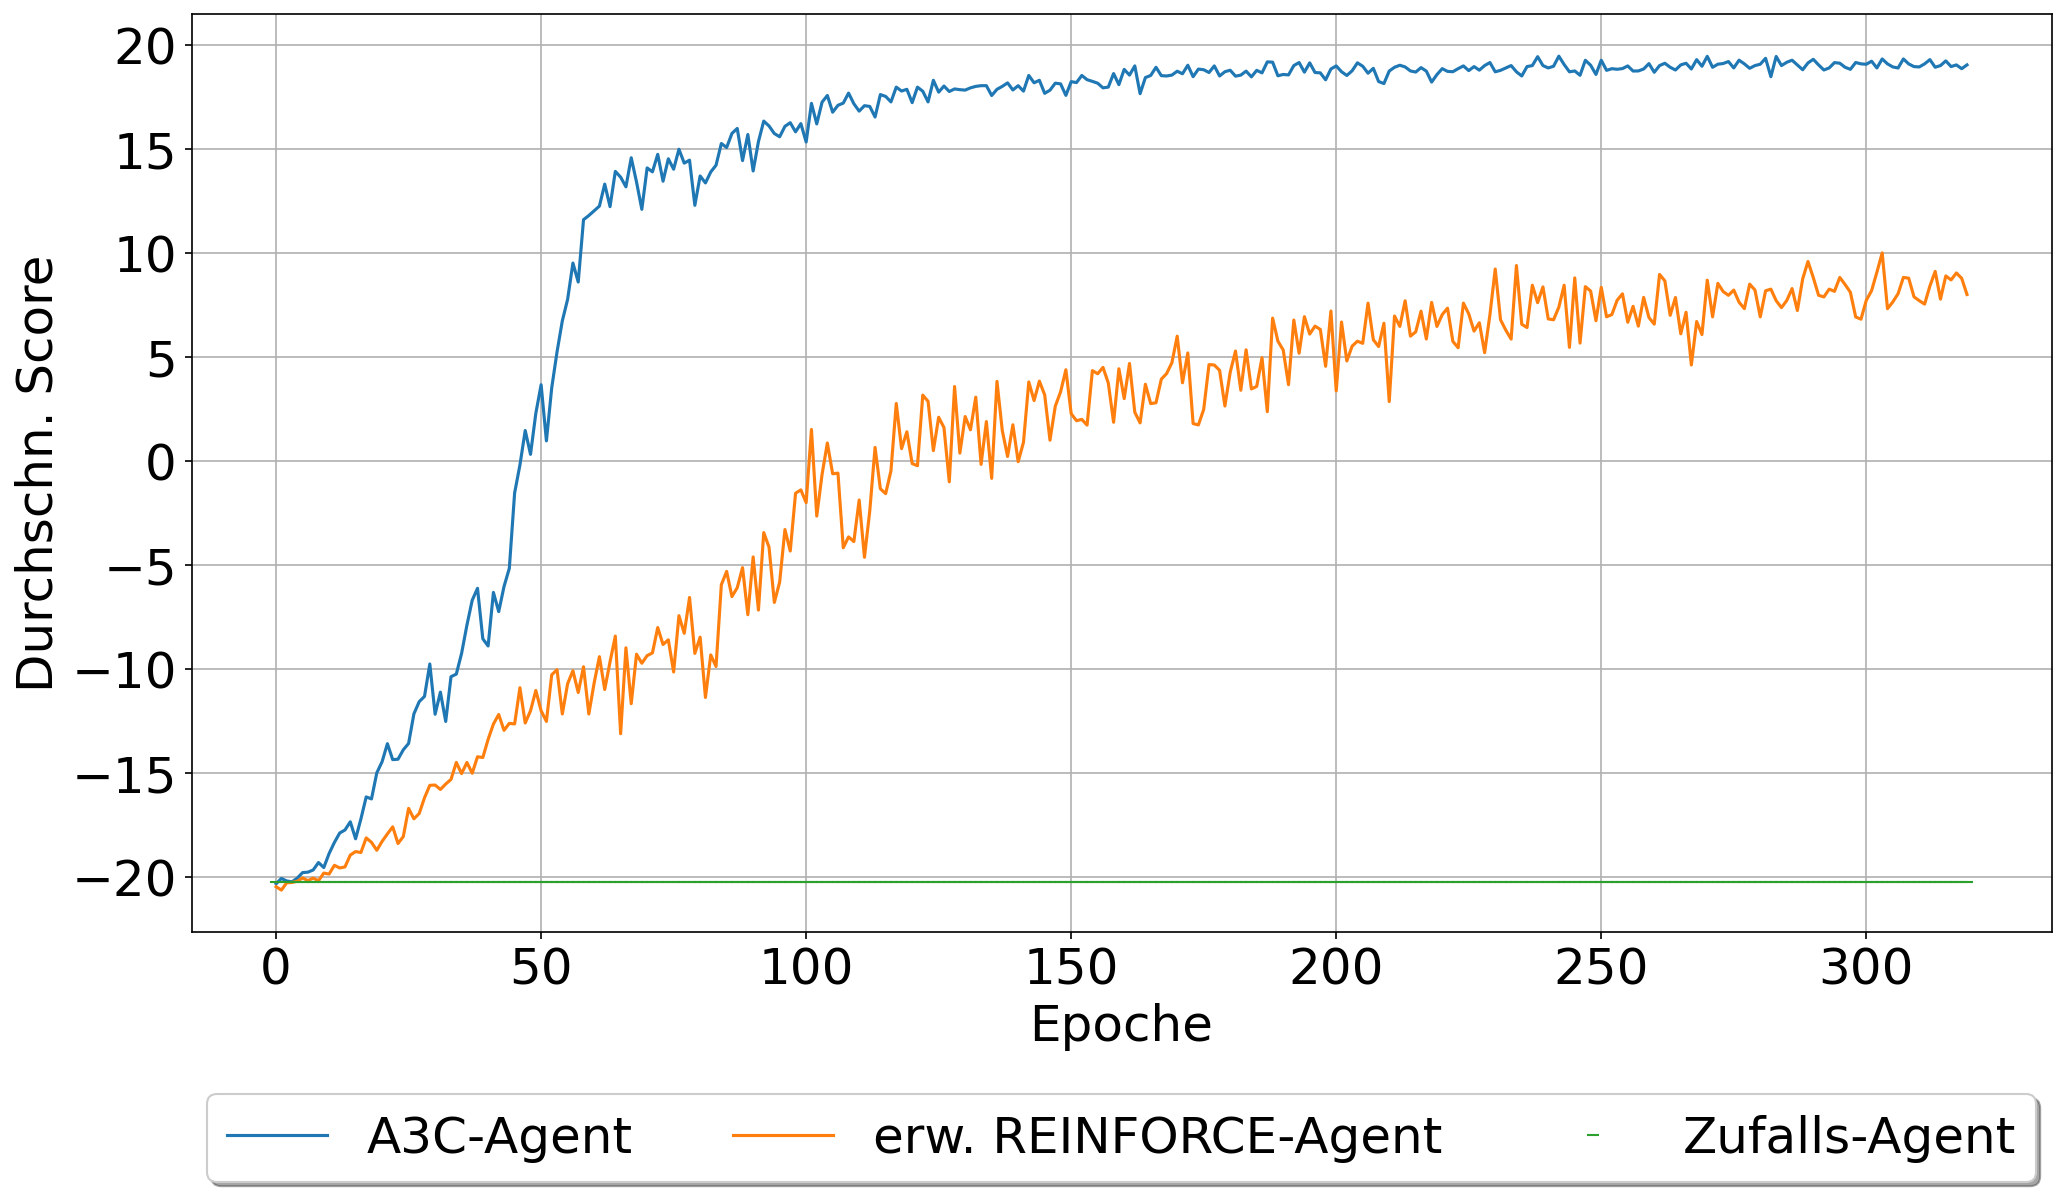

In [17]:
# plot for avg score of experiements and random agent
plt.figure(figsize=(16, 9), dpi=150)
plt.plot("advantage", "-", data=training_mean)
plt.plot("disadvantage", data=training_mean)
plt.plot("random", "_", data=training_mean)
plt.ylabel("Durchschn. Score")
plt.xlabel("Epoche")
# plt.title("Durchschn. Score je Evaluations-Epoche", fontdict={"fontsize": 30})
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height*0.9])
plt.legend(labels=["A3C-Agent","erw. REINFORCE-Agent", "Zufalls-Agent"],
            loc='lower center',
            ncol=3,
            bbox_to_anchor=[0.5, -0.3],
            fancybox=True,
            shadow=True)
plt.grid(which="major",
            axis="both")
plt.rcParams.update({'font.size': 24})
plt.savefig("figs/avg_training_score.png", bbox_inches = "tight")
plt.show()

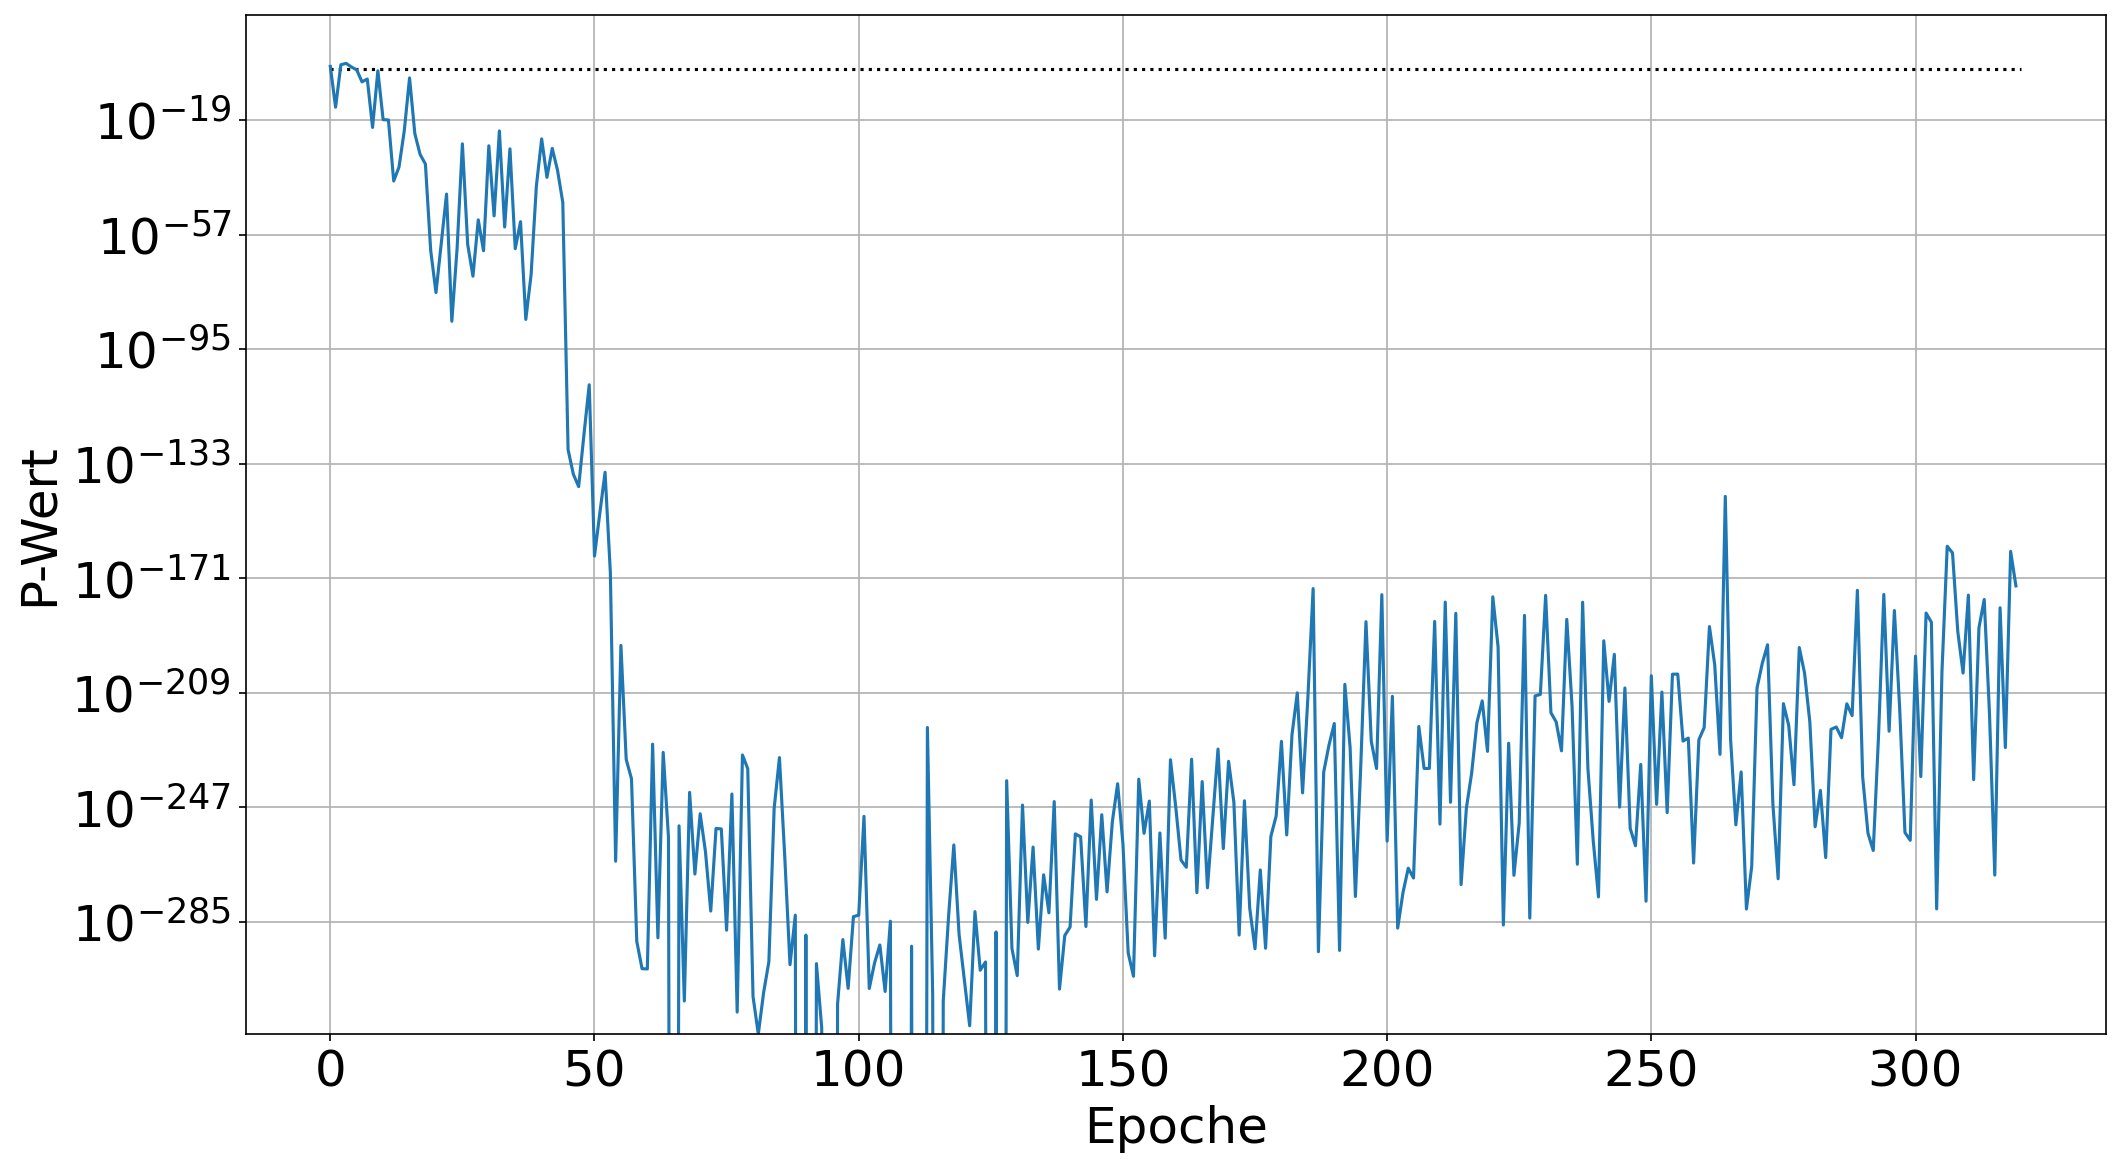

In [15]:
# plot for ttest p-value
plt.figure(figsize=(16, 9), dpi=150)
plt.plot("t-test_p-wert", data=df_experiments_tests)
plt.xlabel("Epoche")
plt.ylabel("P-Wert")
# plt.title("P-Werte der T-Tests je Evaluations-Epoche",
    # fontdict={"fontsize": 30})
plt.grid(which="major",
            axis="both")
plt.hlines(0.01, xmin=0, xmax=320, linestyles="dotted", label="strong effect")
plt.yscale(value="log")
plt.rcParams.update({'font.size': 24})
plt.savefig("figs/t-test.png", bbox_inches = "tight")
plt.show()

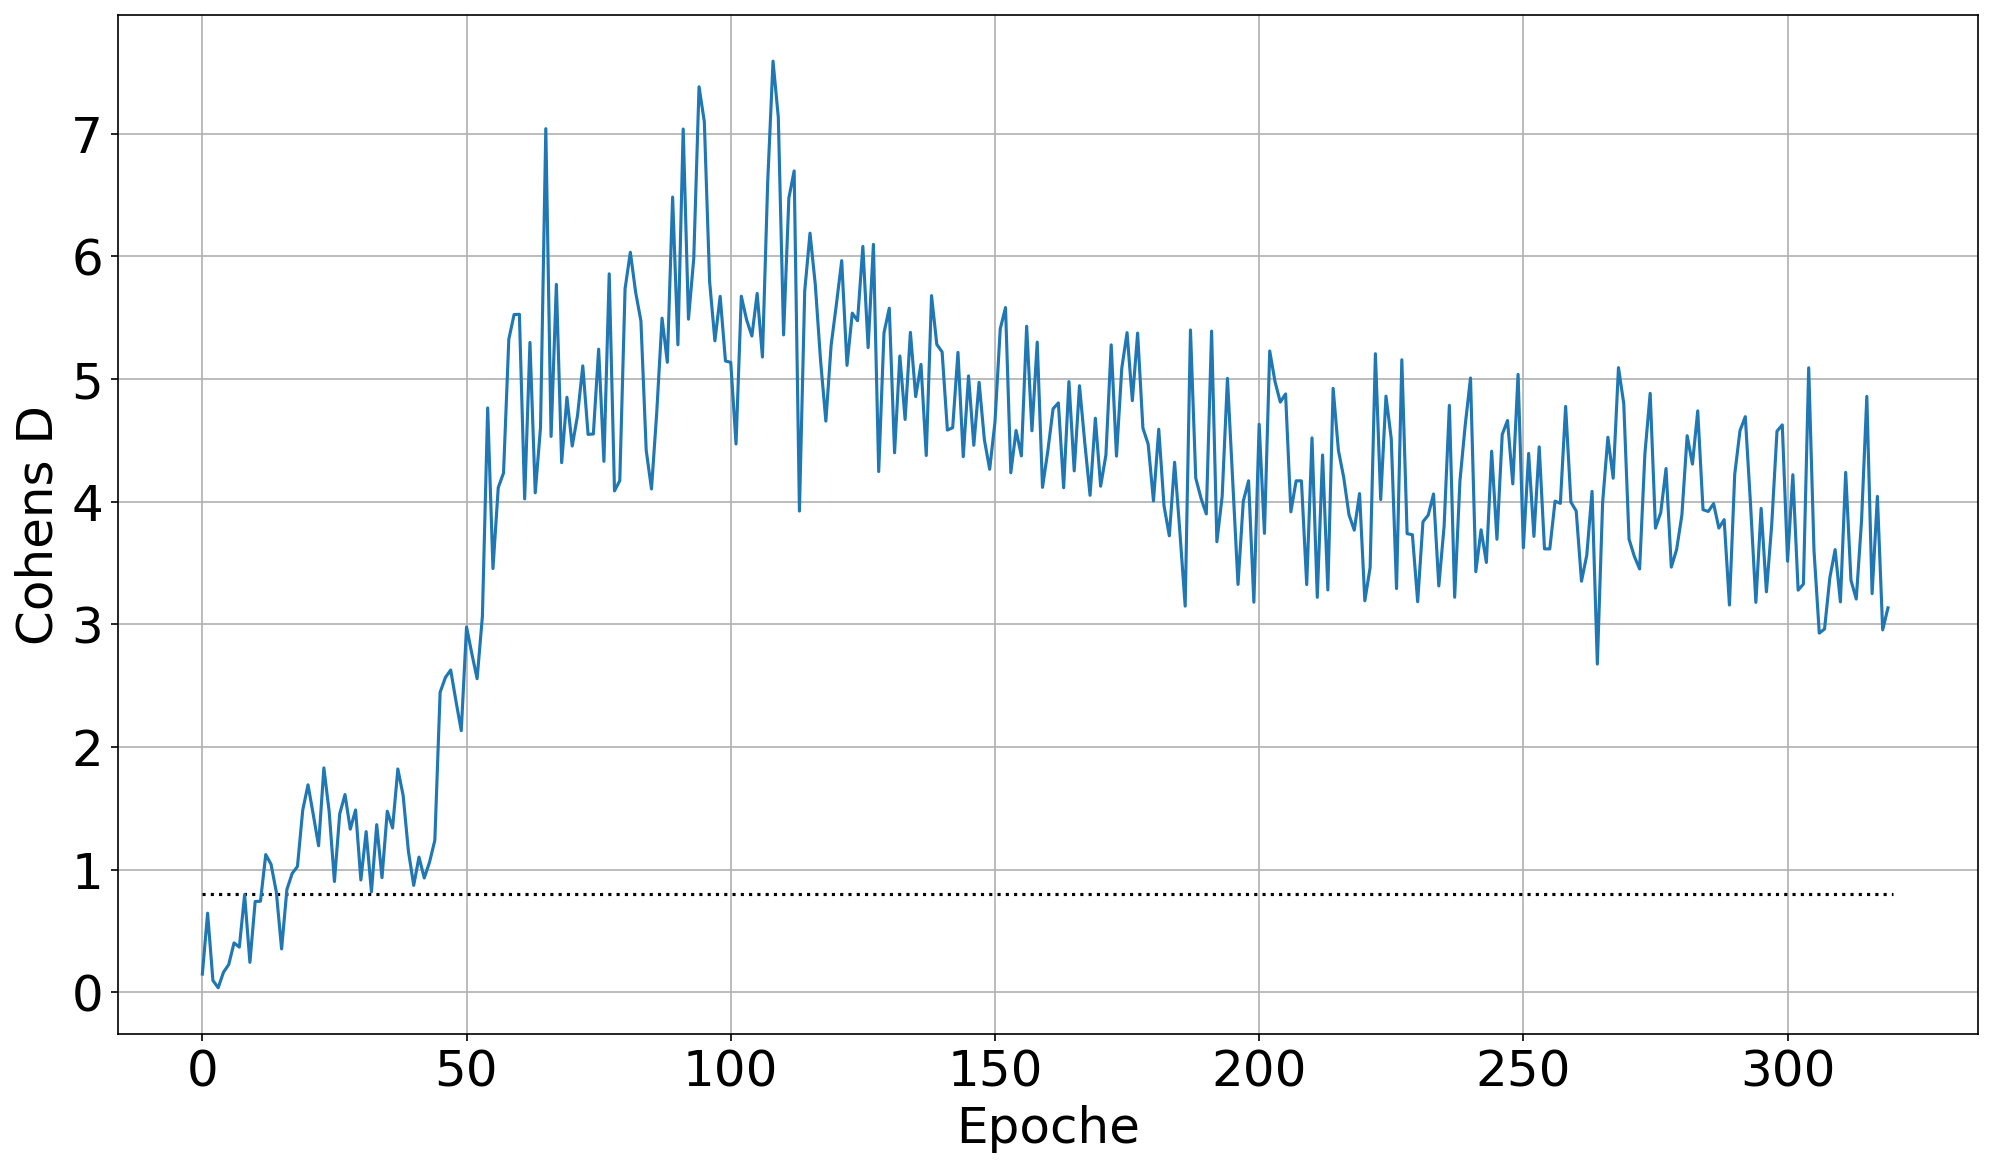

In [16]:
# plot for cohen's d values
plt.figure(figsize=(16, 9), dpi=150)
plt.plot("cohens_d", "-", data=df_experiments_tests)
plt.xlabel("Epoche")
plt.ylabel("Cohens D")
# plt.title("Cohens D je Evaluations-Epoche", fontdict={"fontsize": 30})
plt.grid(which="major",
            axis="both")
plt.hlines(0.8, xmin=0, xmax=320, linestyles="dotted", label="strong effect")
plt.rcParams.update({'font.size': 24})
plt.savefig("figs/cohens_d.png", bbox_inches = "tight")
plt.show()